# Trabajo Practico 1
### 82.20 Analisis Predictivo Avanzado
### Bruno Soifer - Azul de los Angeles Makk

# EDA

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
import kds

warnings.filterwarnings("ignore")

In [2]:
datos = pd.read_csv("./dataset.csv")
datosFiltrados = datos[datos['track_genre'].isin(['classical', 'metal', 'jazz', 'punk-rock',
                                                  'techno', 'reggae', 'sleep', 'trance',
                                                  'study', 'hip-hop'])]


In [3]:
print(datosFiltrados.describe())

datosNumericos = datosFiltrados[['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
                                 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                                 'valence', 'tempo']]

         Unnamed: 0    popularity   duration_ms  danceability        energy  \
count   10000.00000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean    80499.50000     30.486900  2.224682e+05      0.546592      0.594577   
std     28586.09889     25.234736  1.330844e+05      0.210089      0.301225   
min     16000.00000      0.000000  1.745300e+04      0.000000      0.000000   
25%     64499.75000      1.000000  1.560000e+05      0.418000      0.357000   
50%     86999.50000     35.000000  2.022830e+05      0.577500      0.664000   
75%    105499.25000     49.000000  2.549200e+05      0.712000      0.857000   
max    110999.00000     99.000000  4.120258e+06      0.964000      1.000000   

                key      loudness          mode   speechiness  acousticness  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       5.297200    -10.379438      0.608900      0.078617      0.343085   
std        3.573283      7.673109      0.488021    

In [4]:
print(datosFiltrados.columns[datosFiltrados.isna().any()])

Index([], dtype='object')


In [5]:
scaler = MinMaxScaler()
dat_c = scaler.fit_transform(datosNumericos)
dat_c = pd.DataFrame(dat_c, columns=datosNumericos.columns)

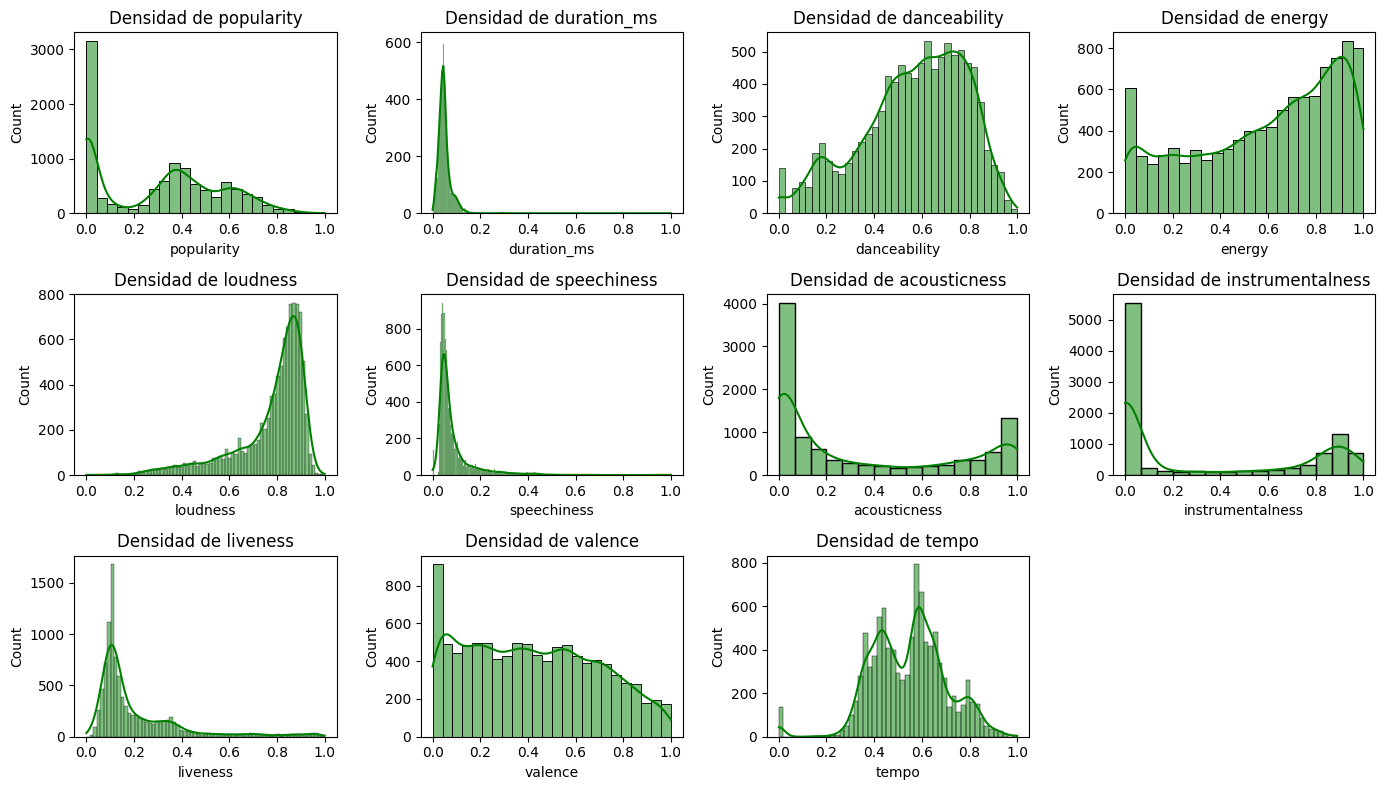

In [6]:
# Densidad de variables numericas
plt.figure(figsize=(14, 8))
for i, colname in enumerate(dat_c.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(dat_c[colname], kde=True, color='green', alpha=0.5)
    plt.title(f"Densidad de {colname}")
plt.tight_layout()
plt.show()

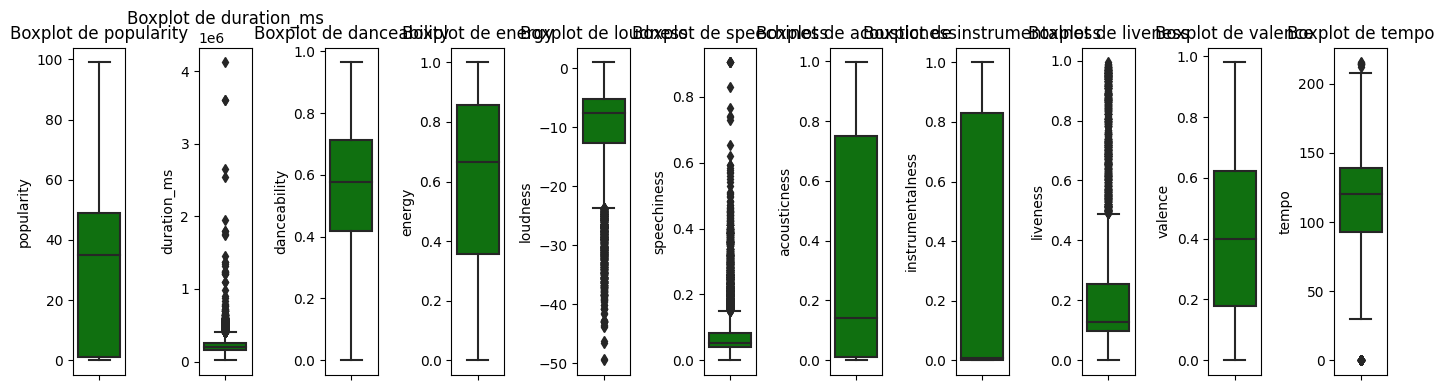

In [7]:
# Análisis de outliers
num_cols = len(datosNumericos.columns)
plt.figure(figsize=(14, 4))
for i, colname in enumerate(datosNumericos.columns):
    plt.subplot(1, num_cols, i+1)
    sns.boxplot(y=datosNumericos[colname], color='green')
    plt.title(f"Boxplot de {colname}")
plt.tight_layout()
plt.show()

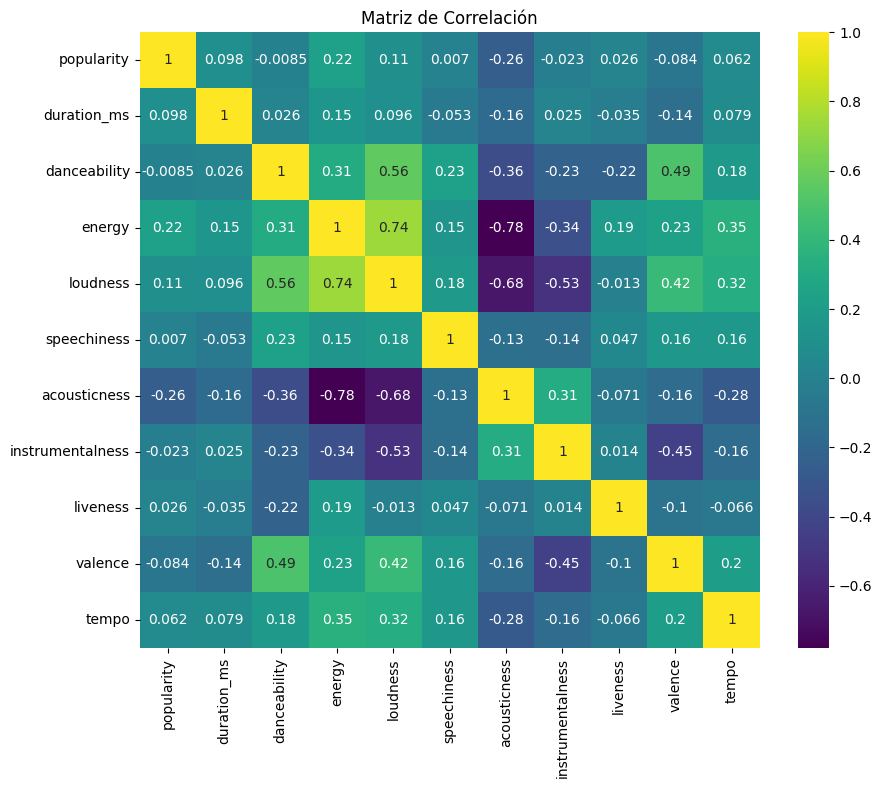

In [8]:
# Matriz de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(datosNumericos.corr(), annot=True, cmap='viridis')
plt.title("Matriz de Correlación")
plt.show()

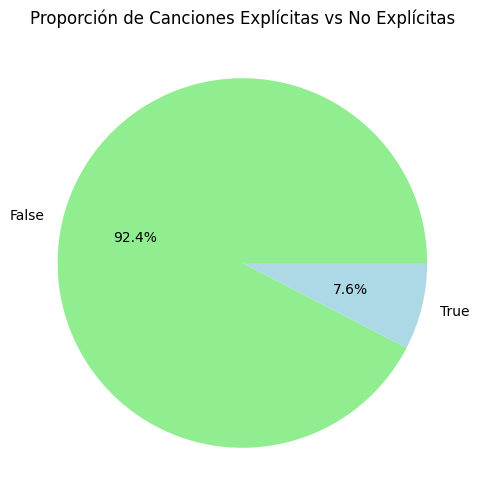

In [9]:
# Pie chart de proporcion explicit
plt.figure(figsize=(6, 6))
datosFiltrados['explicit'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
plt.title("Proporción de Canciones Explícitas vs No Explícitas")
plt.ylabel("")
plt.show()

In [10]:
# Testing de hipótesis
## Se separa la data en dos grupos para realizar t-test.
grupo_1 = datosFiltrados[datosFiltrados['explicit'] == 'True']
grupo_2 = datosFiltrados[datosFiltrados['explicit'] == 'False']

In [11]:
## Se realiza el t-test
test_result = ttest_ind(grupo_1['popularity'], grupo_2['popularity'])
print("Test de Hipótesis:")
print(test_result)

Test de Hipótesis:
Ttest_indResult(statistic=nan, pvalue=nan)


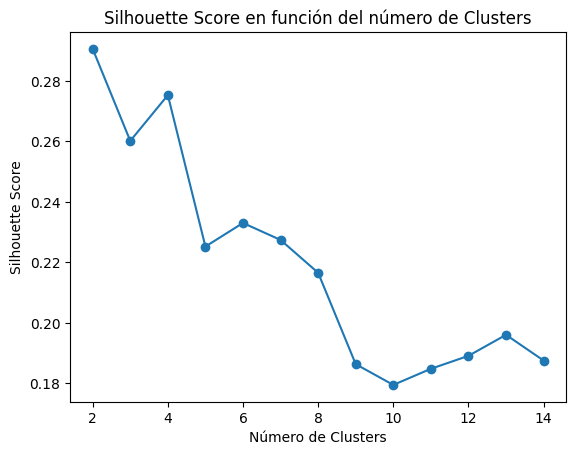

In [12]:
# Clustering jerárquico
## Se escoge el número óptimo de clusters
k = 15
k_vec = np.arange(2, k)
silhouette_vec = np.zeros(k-2)
for i in range(0, k-2):
    modelo = AgglomerativeClustering(n_clusters=i+2)
    modelo.fit(dat_c)
    labels = modelo.labels_
    silhouette_vec[i] = silhouette_score(dat_c, labels)

plt.plot(k_vec, silhouette_vec, marker='o')
plt.title("Silhouette Score en función del número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [13]:
## Se realiza el clustering jerárquico
modelo = AgglomerativeClustering(n_clusters=6)
labels = modelo.fit_predict(dat_c)
dat_c['cluster'] = labels

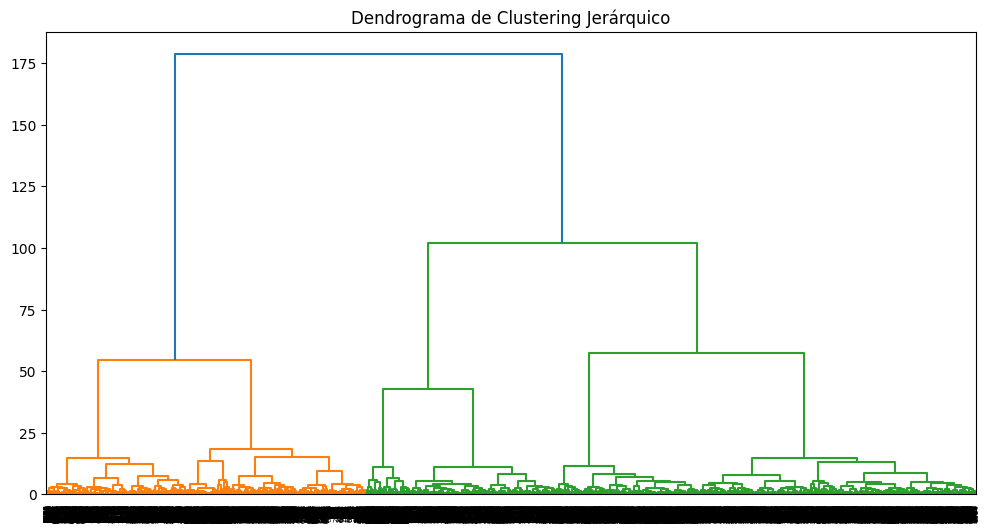

In [14]:
## Se visualiza el dendrograma
plt.figure(figsize=(12, 6))
plt.title("Dendrograma de Clustering Jerárquico")
Z = linkage(dat_c, 'ward')
dendrogram(Z)
plt.show()

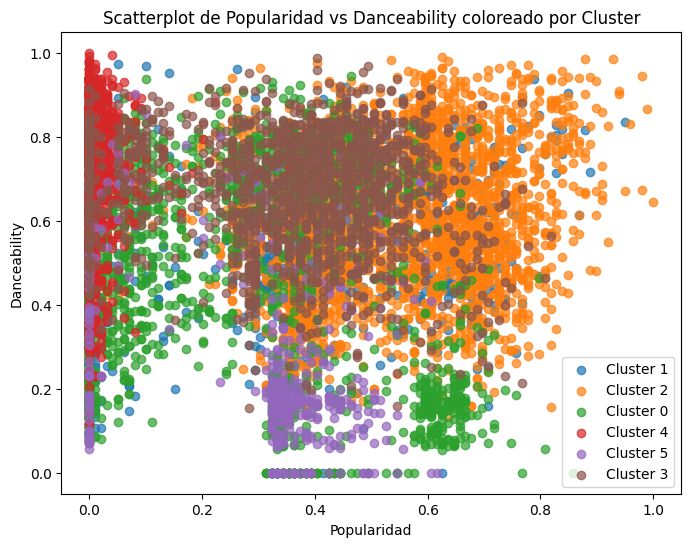

In [15]:
## Se hace un scatterplot de las observaciones coloreado por cluster
plt.figure(figsize=(8, 6))
for cluster in dat_c['cluster'].unique():
    plt.scatter(dat_c[dat_c['cluster']==cluster]['popularity'], 
                dat_c[dat_c['cluster']==cluster]['danceability'],
                label=f'Cluster {cluster}', alpha=0.7)
plt.title("Scatterplot de Popularidad vs Danceability coloreado por Cluster")
plt.xlabel("Popularidad")
plt.ylabel("Danceability")
plt.legend()
plt.show()

In [16]:
## Se hace un resumen de la media de las variables numéricas por cluster
resumen_cluster = dat_c.groupby('cluster').agg('mean').reset_index()
print(resumen_cluster)

   cluster  popularity  duration_ms  danceability    energy  loudness  \
0        0    0.256777     0.038960      0.426209  0.194176  0.581069   
1        1    0.201443     0.047009      0.519081  0.358023  0.740808   
2        2    0.522374     0.049985      0.602125  0.795742  0.865098   
3        3    0.365634     0.068799      0.668657  0.738250  0.818355   
4        4    0.010197     0.047172      0.703886  0.739353  0.870925   
5        5    0.312977     0.052057      0.278840  0.779096  0.636611   

   speechiness  acousticness  instrumentalness  liveness   valence     tempo  
0     0.072756      0.809115          0.833138  0.167761  0.273334  0.464246  
1     0.064767      0.765234          0.032702  0.180767  0.461415  0.510470  
2     0.100247      0.090007          0.018364  0.240674  0.527450  0.594511  
3     0.072063      0.059948          0.741585  0.147891  0.310580  0.590602  
4     0.118981      0.117659          0.012036  0.167661  0.566589  0.565011  
5     0.072330

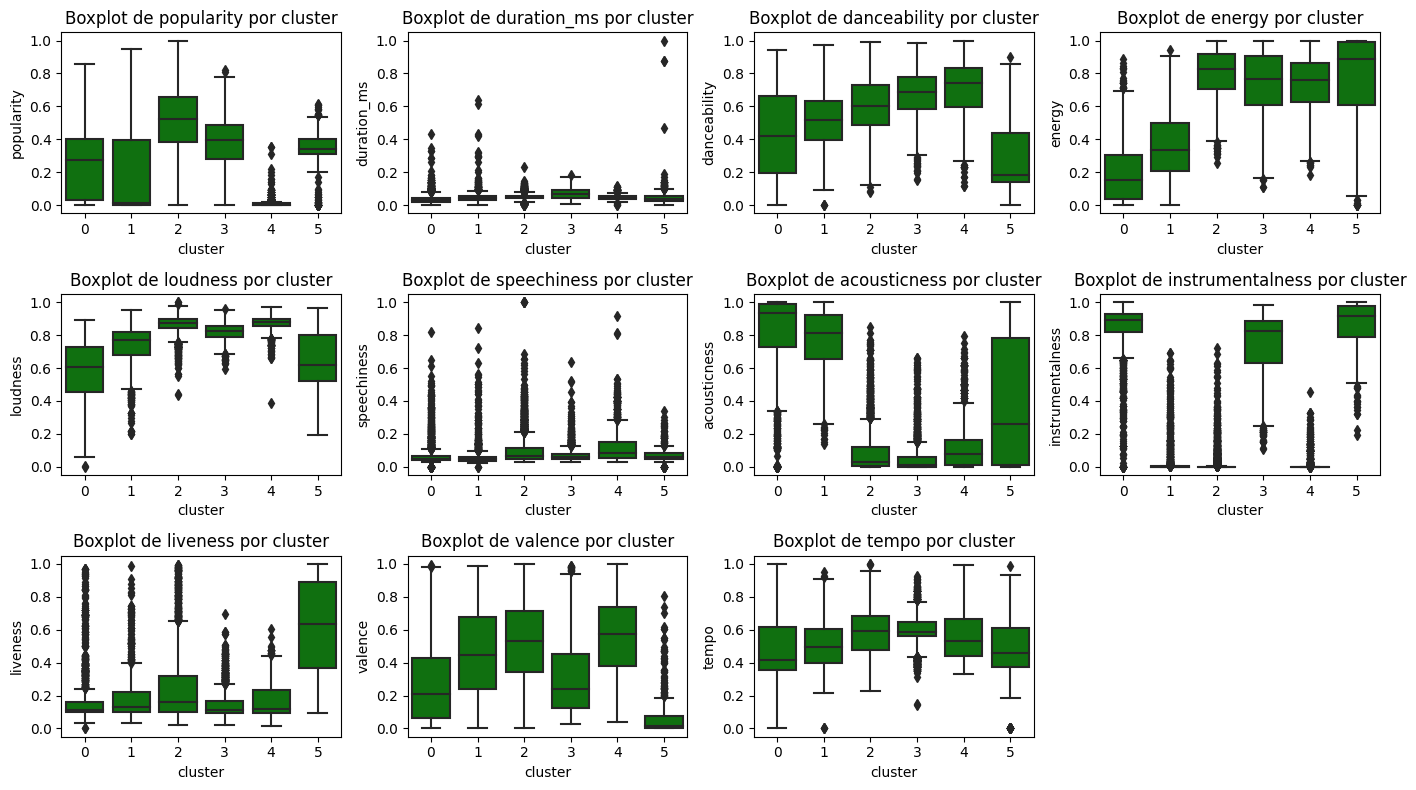

In [17]:
## Se hace un boxplot de las variables numéricas por cluster
plt.figure(figsize=(14, 8))
for i, colname in enumerate(datosNumericos.columns):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='cluster', y=colname, data=dat_c, color='green')
    plt.title(f"Boxplot de {colname} por cluster")
plt.tight_layout()
plt.show()

# Encoders

In [44]:
df = datosFiltrados.copy()
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['track_id'], axis=1)

In [45]:
print(df.columns)

Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')


In [46]:
def label_encoder(data):
    le = LabelEncoder()
    encoded_data = le.fit_transform(data)
    return encoded_data

In [47]:
df['track_genre_encoded'] = label_encoder(df['track_genre'])

print(df[['track_genre', 'track_genre_encoded']])
df = df.drop(['track_genre'], axis=1)

       track_genre  track_genre_encoded
16000    classical                    0
16001    classical                    0
16002    classical                    0
16003    classical                    0
16004    classical                    0
...            ...                  ...
110995      trance                    9
110996      trance                    9
110997      trance                    9
110998      trance                    9
110999      trance                    9

[10000 rows x 2 columns]


In [48]:
df['artists_encoded'] = label_encoder(df['artists'])

print(df[['artists', 'artists_encoded']])
df = df.drop(['artists'], axis=1)

                                                  artists  artists_encoded
16000                                     Bombay Jayashri              536
16001   Shankar;Ehsaan;Loy;Alisha Chinai;Shankar Mahad...             2811
16002                            Bombay Jayashri;DJ Aftab              537
16003                                     Bombay Jayashri              536
16004                            Bombay Jayashri;Swattrex              540
...                                                   ...              ...
110995                                   NG Rezonance;PHD             2162
110996                                   NG Rezonance;PHD             2162
110997                                NG Rezonance;Begbie             2159
110998                                       NG Rezonance             2156
110999                                       NG Rezonance             2156

[10000 rows x 2 columns]


In [49]:
df.drop(['track_name', 'album_name'], axis=1, inplace=True)

In [50]:
df['explicit'] = df['explicit'].astype(int)

In [51]:
columns_with_nas = df.columns[df.isna().any()].tolist()

if columns_with_nas:
    print("Columns with missing values:", columns_with_nas)
else:
    print("No missing values found in any column.")

No missing values found in any column.


In [52]:
columns_to_scale = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

X = df.drop(columns=['explicit']) 
y = df['explicit']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

scaler.fit(X_train[columns_to_scale])

X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [53]:
m = XGBClassifier()

# RandomUnderSampler

In [54]:
rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 7388, 1: 612})
Resample dataset shape Counter({0: 612, 1: 612})


ROCAUC score Under-sampling: 0.86
Accuracy score: 0.82
F1 score: 0.43
Confusion matrix:


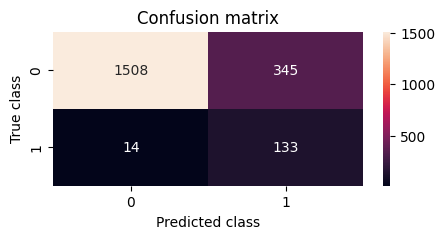

In [55]:
x_rus, y_rus = rus.fit_resample(X_train, y_train)

m.fit(x_rus, y_rus)
predict_y = m.predict(X_test)
print('ROCAUC score Under-sampling:',round(roc_auc_score(y_test, predict_y),2))
print('Accuracy score:', round(accuracy_score(y_test, predict_y), 2))
print('F1 score:', round(f1_score(y_test, predict_y), 2))
print('Confusion matrix:')
conf_matrix = confusion_matrix(y_test, predict_y)
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d")
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

In [56]:
y_pred_proba = m.predict_proba(X_test)

In [57]:
chart=kds.metrics.decile_table(y_test, y_pred_proba[:,1],labels=False)
chart['lift_decil']=chart['cnt_resp']/chart['cnt_resp_rndm']

chart2=chart.loc[:,['decile','cnt_cust','cum_cust','cum_cust_pct','cnt_resp','cum_resp','cum_resp_pct','cnt_non_resp','cum_non_resp','cum_non_resp_pct','lift','lift_decil','KS']]
chart2.columns=['decil','tot','tot_acum','tot_acum_porc','pos','pos_acum','pos_acum_porc','neg','neg_acum','neg_acum_porc','lift','lift_decil','KS']
chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])]=chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])].astype('int')

pcs_gain=np.percentile(y_pred_proba[:,1], np.arange(0, 100, 10))
pcs_gain[::-1].sort()
pcs_gain=np.round(pcs_gain,3)
chart2=pd.concat([pd.Series(pcs_gain),chart2],axis=1)
chart2.rename(columns={0:'punto_corte'},inplace=True)

chart2

,punto_corte,decil,tot,tot_acum,tot_acum_porc,pos,pos_acum,pos_acum_porc,neg,neg_acum,neg_acum_porc,lift,lift_decil,KS
0,0.957,1,200.0,200.0,10.0,103.0,103.0,70.0,97.0,97.0,5.0,7.007,7.006803,64.0
1,0.669,2,200.0,400.0,20.0,27.0,130.0,88.0,173.0,270.0,14.0,4.422,1.836735,73.0
2,0.289,3,200.0,600.0,30.0,9.0,139.0,94.0,191.0,461.0,24.0,3.152,0.612245,69.0
3,0.087,4,200.0,800.0,40.0,5.0,144.0,97.0,195.0,656.0,35.0,2.449,0.340136,62.0
4,0.023,5,200.0,1000.0,50.0,3.0,147.0,100.0,197.0,853.0,46.0,2.000,0.204082,53.0
5,0.007,6,200.0,1200.0,60.0,0.0,147.0,100.0,200.0,1053.0,56.0,1.667,0.000000,43.0
6,0.001,7,200.0,1400.0,70.0,0.0,147.0,100.0,200.0,1253.0,67.0,1.429,0.000000,32.0
7,0.000,8,200.0,1600.0,80.0,0.0,147.0,100.0,200.0,1453.0,78.0,1.250,0.000000,21.0
8,0.000,9,200.0,1800.0,90.0,0.0,147.0,100.0,200.0,1653.0,89.0,1.111,0.000000,10.0
9,0.000,10,200.0,2000.0,100.0,0.0,147.0,100.0,200.0,1853.0,100.0,1.000,0.000000,0.0


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.957,1.000,0.986,200.0,103.0,97.0,14.7,147,51.5,200.0,103.0,147,97.0,10.0,70.068,100.0,5.235,64.833,7.007
1,2,0.670,0.957,0.833,200.0,27.0,173.0,14.7,0,13.5,400.0,130.0,147,270.0,20.0,88.435,100.0,14.571,73.864,4.422
2,3,0.289,0.669,0.461,200.0,9.0,191.0,14.7,0,4.5,600.0,139.0,147,461.0,30.0,94.558,100.0,24.879,69.679,3.152
3,4,0.088,0.289,0.177,200.0,5.0,195.0,14.7,0,2.5,800.0,144.0,147,656.0,40.0,97.959,100.0,35.402,62.557,2.449
4,5,0.023,0.087,0.049,200.0,3.0,197.0,14.7,0,1.5,1000.0,147.0,147,853.0,50.0,100.000,100.0,46.033,53.967,2.000
5,6,0.007,0.023,0.013,200.0,0.0,200.0,14.7,0,0.0,1200.0,147.0,147,1053.0,60.0,100.000,100.0,56.827,43.173,1.667
6,7,0.001,0.007,0.003,200.0,0.0,200.0,14.7,0,0.0,1400.0,147.0,147,1253.0,70.0,100.000,100.0,67.620,32.380,1.429
7,8,0.000,0.001,0.001,200.0,0.0,200.0,14.7,0,0.0,1600.0,147.0,147,1453.0,80.0,100.000,100.0,78.413,21.587,1.250
8,9,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,1800.0,147.0,147,1653.0,90.0,100.000,100.0,89.207,10.793,1.111
9,10,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,2000.0,147.0,147,1853.0,100.0,100.000,100.0,100.000,0.000,1.000


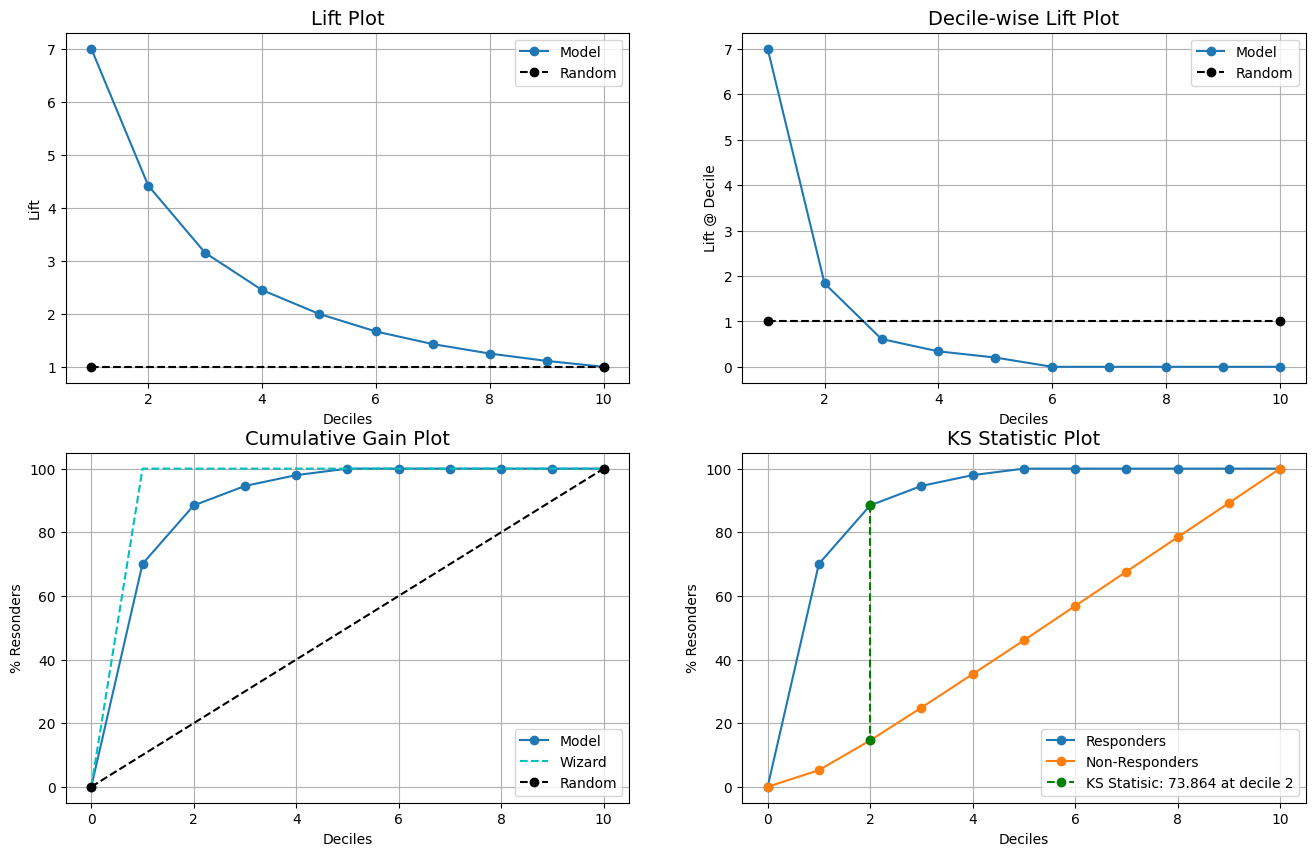

In [58]:
kds.metrics.report(y_test, y_pred_proba[:,1])

# RandomOverSampler

In [59]:
ros = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 7388, 1: 612})
Resample dataset shape Counter({0: 7388, 1: 7388})


ROCAUC score Over-sampling: 0.82
Accuracy score: 0.96
F1 score: 0.69
Confusion matrix:


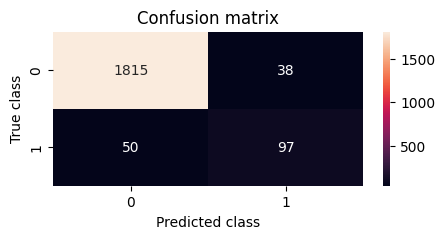

In [60]:
m.fit(x_ros, y_ros)
predict_y = m.predict(X_test)
print('ROCAUC score Over-sampling:',round(roc_auc_score(y_test, predict_y),2))
print('Accuracy score:', round(accuracy_score(y_test, predict_y), 2))
print('F1 score:', round(f1_score(y_test, predict_y), 2))
print('Confusion matrix:')
conf_matrix = confusion_matrix(y_test, predict_y)
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d")
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

In [61]:
y_pred_proba = m.predict_proba(X_test)

In [62]:
chart=kds.metrics.decile_table(y_test, y_pred_proba[:,1],labels=False)
chart['lift_decil']=chart['cnt_resp']/chart['cnt_resp_rndm']

chart2=chart.loc[:,['decile','cnt_cust','cum_cust','cum_cust_pct','cnt_resp','cum_resp','cum_resp_pct','cnt_non_resp','cum_non_resp','cum_non_resp_pct','lift','lift_decil','KS']]
chart2.columns=['decil','tot','tot_acum','tot_acum_porc','pos','pos_acum','pos_acum_porc','neg','neg_acum','neg_acum_porc','lift','lift_decil','KS']
chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])]=chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])].astype('int')

pcs_gain=np.percentile(y_pred_proba[:,1], np.arange(0, 100, 10))
pcs_gain[::-1].sort()
pcs_gain=np.round(pcs_gain,3)
chart2=pd.concat([pd.Series(pcs_gain),chart2],axis=1)
chart2.rename(columns={0:'punto_corte'},inplace=True)

chart2

,punto_corte,decil,tot,tot_acum,tot_acum_porc,pos,pos_acum,pos_acum_porc,neg,neg_acum,neg_acum_porc,lift,lift_decil,KS
0,0.213,1,200.0,200.0,10.0,108.0,108.0,73.0,92.0,92.0,4.0,7.347,7.346939,68.0
1,0.037,2,200.0,400.0,20.0,20.0,128.0,87.0,180.0,272.0,14.0,4.354,1.360544,72.0
2,0.013,3,200.0,600.0,30.0,10.0,138.0,93.0,190.0,462.0,24.0,3.129,0.680272,68.0
3,0.004,4,200.0,800.0,40.0,6.0,144.0,97.0,194.0,656.0,35.0,2.449,0.408163,62.0
4,0.001,5,200.0,1000.0,50.0,2.0,146.0,99.0,198.0,854.0,46.0,1.986,0.136054,53.0
5,0.000,6,200.0,1200.0,60.0,0.0,146.0,99.0,200.0,1054.0,56.0,1.655,0.000000,42.0
6,0.000,7,200.0,1400.0,70.0,1.0,147.0,100.0,199.0,1253.0,67.0,1.429,0.068027,32.0
7,0.000,8,200.0,1600.0,80.0,0.0,147.0,100.0,200.0,1453.0,78.0,1.250,0.000000,21.0
8,0.000,9,200.0,1800.0,90.0,0.0,147.0,100.0,200.0,1653.0,89.0,1.111,0.000000,10.0
9,0.000,10,200.0,2000.0,100.0,0.0,147.0,100.0,200.0,1853.0,100.0,1.000,0.000000,0.0


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.216,1.000,0.708,200.0,108.0,92.0,14.7,147,54.0,200.0,108.0,147,92.0,10.0,73.469,100.0,4.965,68.504,7.347
1,2,0.037,0.212,0.090,200.0,20.0,180.0,14.7,0,10.0,400.0,128.0,147,272.0,20.0,87.075,100.0,14.679,72.396,4.354
2,3,0.013,0.037,0.023,200.0,10.0,190.0,14.7,0,5.0,600.0,138.0,147,462.0,30.0,93.878,100.0,24.933,68.945,3.129
3,4,0.004,0.013,0.008,200.0,6.0,194.0,14.7,0,3.0,800.0,144.0,147,656.0,40.0,97.959,100.0,35.402,62.557,2.449
4,5,0.001,0.004,0.002,200.0,2.0,198.0,14.7,0,1.0,1000.0,146.0,147,854.0,50.0,99.320,100.0,46.087,53.233,1.986
5,6,0.000,0.001,0.001,200.0,0.0,200.0,14.7,0,0.0,1200.0,146.0,147,1054.0,60.0,99.320,100.0,56.881,42.439,1.655
6,7,0.000,0.000,0.000,200.0,1.0,199.0,14.7,0,0.5,1400.0,147.0,147,1253.0,70.0,100.000,100.0,67.620,32.380,1.429
7,8,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,1600.0,147.0,147,1453.0,80.0,100.000,100.0,78.413,21.587,1.250
8,9,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,1800.0,147.0,147,1653.0,90.0,100.000,100.0,89.207,10.793,1.111
9,10,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,2000.0,147.0,147,1853.0,100.0,100.000,100.0,100.000,0.000,1.000


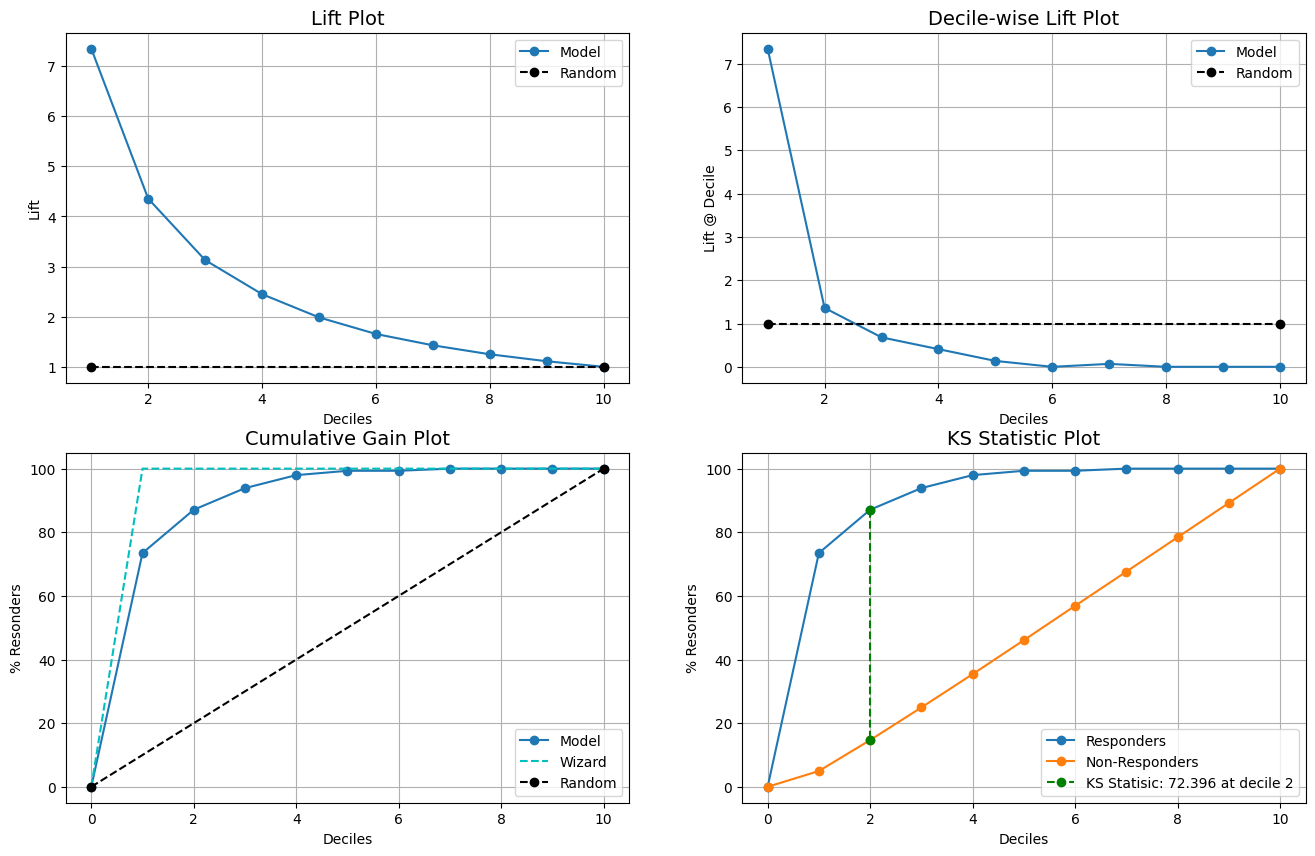

In [63]:
kds.metrics.report(y_test, y_pred_proba[:,1])

# Synthetic Minority Oversampling Technique (SMOTE)

In [64]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 7388, 1: 612})
Resample dataset shape Counter({0: 7388, 1: 7388})


ROCAUC score SMOTE: 0.83
Accuracy score: 0.94
F1 score: 0.64
Confusion matrix:


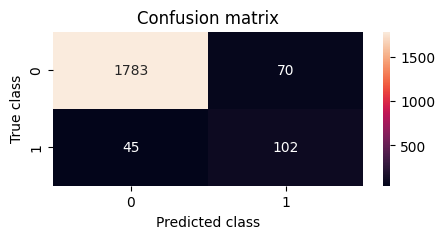

In [65]:
m.fit(x_smote, y_smote)
predict_y = m.predict(X_test)
print('ROCAUC score SMOTE:',round(roc_auc_score(y_test, predict_y),2))
print('Accuracy score:', round(accuracy_score(y_test, predict_y), 2))
print('F1 score:', round(f1_score(y_test, predict_y), 2))
print('Confusion matrix:')
conf_matrix = confusion_matrix(y_test, predict_y)
plt.figure(figsize=(5, 2)); sns.heatmap(conf_matrix,  annot=True, fmt="d")
plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class');plt.show()

In [66]:
y_pred_proba = m.predict_proba(X_test)

In [67]:
chart=kds.metrics.decile_table(y_test, y_pred_proba[:,1],labels=False)
chart['lift_decil']=chart['cnt_resp']/chart['cnt_resp_rndm']

chart2=chart.loc[:,['decile','cnt_cust','cum_cust','cum_cust_pct','cnt_resp','cum_resp','cum_resp_pct','cnt_non_resp','cum_non_resp','cum_non_resp_pct','lift','lift_decil','KS']]
chart2.columns=['decil','tot','tot_acum','tot_acum_porc','pos','pos_acum','pos_acum_porc','neg','neg_acum','neg_acum_porc','lift','lift_decil','KS']
chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])]=chart2.loc[:,chart2.columns.difference(['lift','lift_decil'])].astype('int')

pcs_gain=np.percentile(y_pred_proba[:,1], np.arange(0, 100, 10))
pcs_gain[::-1].sort()
pcs_gain=np.round(pcs_gain,3)
chart2=pd.concat([pd.Series(pcs_gain),chart2],axis=1)
chart2.rename(columns={0:'punto_corte'},inplace=True)

chart2

,punto_corte,decil,tot,tot_acum,tot_acum_porc,pos,pos_acum,pos_acum_porc,neg,neg_acum,neg_acum_porc,lift,lift_decil,KS
0,0.369,1,200.0,200.0,10.0,107.0,107.0,72.0,93.0,93.0,5.0,7.279,7.278912,67.0
1,0.059,2,200.0,400.0,20.0,21.0,128.0,87.0,179.0,272.0,14.0,4.354,1.428571,72.0
2,0.015,3,200.0,600.0,30.0,7.0,135.0,91.0,193.0,465.0,25.0,3.061,0.476190,66.0
3,0.004,4,200.0,800.0,40.0,6.0,141.0,95.0,194.0,659.0,35.0,2.398,0.408163,60.0
4,0.001,5,200.0,1000.0,50.0,2.0,143.0,97.0,198.0,857.0,46.0,1.946,0.136054,51.0
5,0.000,6,200.0,1200.0,60.0,3.0,146.0,99.0,197.0,1054.0,56.0,1.655,0.204082,42.0
6,0.000,7,200.0,1400.0,70.0,1.0,147.0,100.0,199.0,1253.0,67.0,1.429,0.068027,32.0
7,0.000,8,200.0,1600.0,80.0,0.0,147.0,100.0,200.0,1453.0,78.0,1.250,0.000000,21.0
8,0.000,9,200.0,1800.0,90.0,0.0,147.0,100.0,200.0,1653.0,89.0,1.111,0.000000,10.0
9,0.000,10,200.0,2000.0,100.0,0.0,147.0,100.0,200.0,1853.0,100.0,1.000,0.000000,0.0


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.372,1.000,0.793,200.0,107.0,93.0,14.7,147,53.5,200.0,107.0,147,93.0,10.0,72.789,100.0,5.019,67.770,7.279
1,2,0.059,0.368,0.172,200.0,21.0,179.0,14.7,0,10.5,400.0,128.0,147,272.0,20.0,87.075,100.0,14.679,72.396,4.354
2,3,0.015,0.059,0.033,200.0,7.0,193.0,14.7,0,3.5,600.0,135.0,147,465.0,30.0,91.837,100.0,25.094,66.743,3.061
3,4,0.004,0.015,0.008,200.0,6.0,194.0,14.7,0,3.0,800.0,141.0,147,659.0,40.0,95.918,100.0,35.564,60.354,2.398
4,5,0.001,0.004,0.002,200.0,2.0,198.0,14.7,0,1.0,1000.0,143.0,147,857.0,50.0,97.279,100.0,46.249,51.030,1.946
5,6,0.000,0.001,0.001,200.0,3.0,197.0,14.7,0,1.5,1200.0,146.0,147,1054.0,60.0,99.320,100.0,56.881,42.439,1.655
6,7,0.000,0.000,0.000,200.0,1.0,199.0,14.7,0,0.5,1400.0,147.0,147,1253.0,70.0,100.000,100.0,67.620,32.380,1.429
7,8,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,1600.0,147.0,147,1453.0,80.0,100.000,100.0,78.413,21.587,1.250
8,9,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,1800.0,147.0,147,1653.0,90.0,100.000,100.0,89.207,10.793,1.111
9,10,0.000,0.000,0.000,200.0,0.0,200.0,14.7,0,0.0,2000.0,147.0,147,1853.0,100.0,100.000,100.0,100.000,0.000,1.000


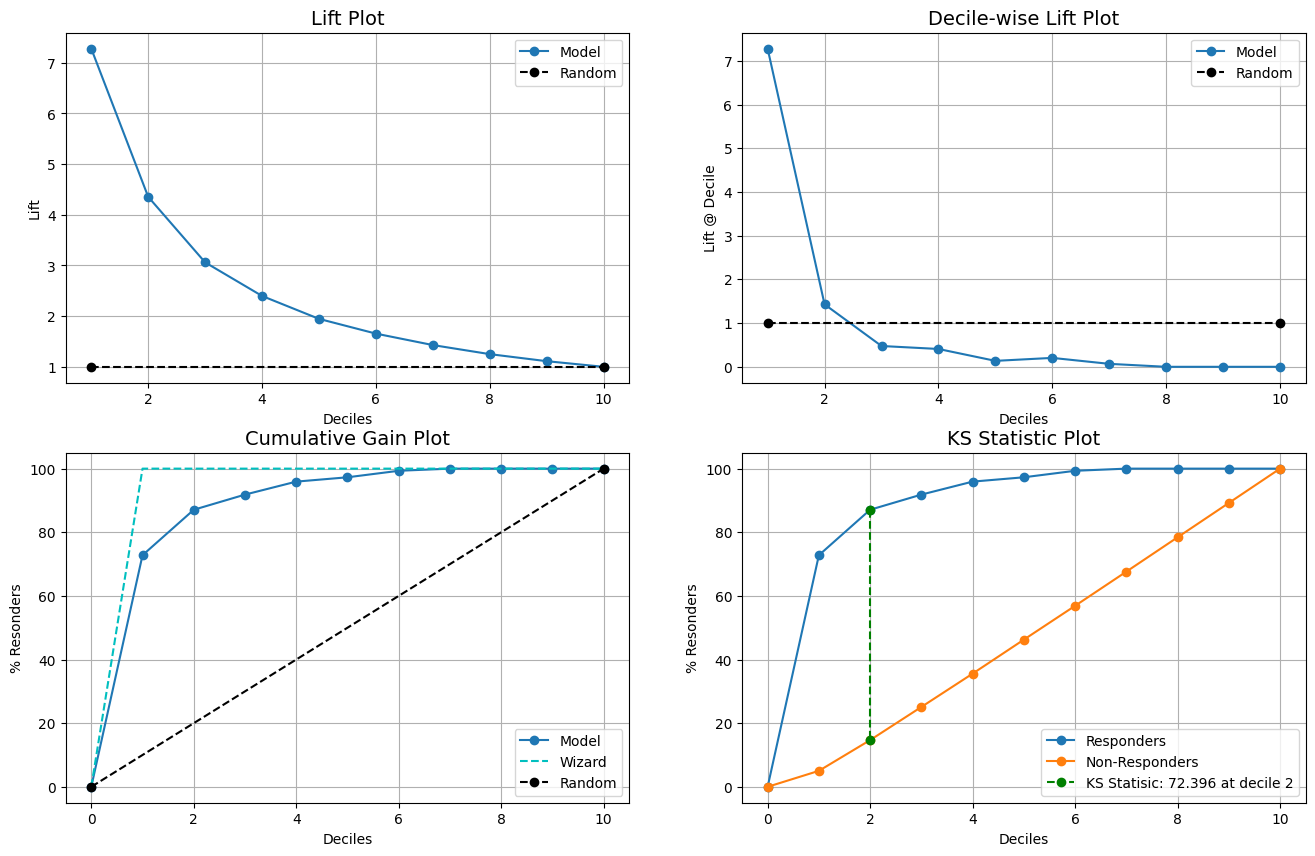

In [68]:
kds.metrics.report(y_test, y_pred_proba[:,1])